# Demo for applying QueST to the DLPFC dataset
This tutorial demonstrates how to use QueST to query spatial niches across 11 reference samples on the DLPFC dataset.

## Preparations
Import modules.

In [1]:
import json
import torch
import logging
import warnings
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import models.model_utils as model_utils
import bench.bench_utils as bench_utils
from torch_geometric.utils import k_hop_subgraph
from models.model import QueSTV1
warnings.filterwarnings("ignore")
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)


Set up niche query problem framework.

In [2]:
dataset = "DLPFC"
save_folder = f"./results/DLPFC"
query_id_list = ["151507"]
ref_id_list = ["151508", "151509", "151510", "151669", "151670", "151671", "151672", "151673", "151674", "151675", "151676"]
niche_prefix_list = ['Layer5_Layer6_100']

Load data.

In [3]:
adata_q = sc.read_h5ad(f"./bench/adata_query/DLPFC/{query_id_list[0]}.h5ad")
adata_ref_list = [sc.read_h5ad(f"./data/DLPFC/adata_filtered/{sample_id}.h5ad") for sample_id in ref_id_list]
with open("./results/DLPFC/param.json", 'r') as f: model_param = json.load(f)

Perfrom data preprocessing, including building spatial graph, normalizationa and HVG selection. Set up the model.

In [4]:
model_utils.build_graphs(adata_list=adata_ref_list, dataset=dataset)
adata_list = model_utils.preprocess_adata([adata_q] + adata_ref_list, param=model_param)
adata_q, adata_ref_list = adata_list[0], adata_list[1:]

feature_q = model_utils.get_feature(adata_q, query=True, param=model_param, device=model_param['device'])
adj_q = adata_q.obsp['spatial_connectivities'].tocoo()

edge_index_q = torch.tensor(np.vstack((adj_q.row, adj_q.col)), dtype=torch.int64).to(model_param['device'])
feature_list, edge_ind_list, sub_node_sample_list, sub_edge_ind_sample_list, batch_label_list = model_utils.prepare_graph_data(adata_ref_list, model_param)

model = QueSTV1(in_dim=feature_list[0].shape[1], param=model_param, logger=logger).to(model_param['device'])

INFO:models.model_utils:building graphs, time: 2024/10/14 20:52:30
INFO:models.model_utils:preprocessing adata: scale=False, pca=False
INFO:models.model_utils:14521 genes passed the filter with min count > 10, making adata copies
INFO:models.model_utils:selecting hvg for 151507
INFO:models.model_utils:selecting hvg for 151508
INFO:models.model_utils:selecting hvg for 151509
INFO:models.model_utils:selecting hvg for 151510
INFO:models.model_utils:selecting hvg for 151669
INFO:models.model_utils:selecting hvg for 151670
INFO:models.model_utils:selecting hvg for 151671
INFO:models.model_utils:selecting hvg for 151672
INFO:models.model_utils:selecting hvg for 151673
INFO:models.model_utils:selecting hvg for 151674
INFO:models.model_utils:selecting hvg for 151675
INFO:models.model_utils:selecting hvg for 151676
INFO:models.model_utils:12378 union hvg genes selected
INFO:models.model_utils:preprocessing 151507
INFO:models.model_utils:preprocessing 151508
INFO:models.model_utils:preprocessing

## Perform Spatial Niches Query

Train the QueST model.

In [6]:
logger.info(f"starting training model, time: {bench_utils.get_time_str()}")
optimizer = model.build_optimizer()
model.train()
for epoch in range(model_param['epochs']):
    logger.info(f"Epoch: {epoch}, time: {bench_utils.get_time_str()}")
    for i, adata_ref in enumerate(adata_ref_list):
        logger.info(f"   sample {ref_id_list[i]}")
        feature, edge_index = feature_list[i], edge_ind_list[i]
        sub_node_list, sub_edge_ind_list = sub_node_sample_list[i], sub_edge_ind_sample_list[i]
        batch_label = batch_label_list[i]
        min_k, max_k, fix_portion = model_utils.get_shuffle_param(model_param, i, len(adata_ref_list))
        adata_shf, fixed_center, fixed_nodes, shuffle_center, feature_shf = model_utils.shuffle(adata_ref, dataset=dataset, feature=feature,
                                                                                                min_k=min_k, max_k=max_k, fix_portion=fix_portion,
                                                                                                min_shuffle_ratio=model_param['min_shuffle_ratio'],
                                                                                                max_shuffle_ratio=model_param['max_shuffle_ratio'])
        shuffle_center_sampled = np.random.choice(shuffle_center, size=len(fixed_center), replace=False)
        recon, logits_positive, logits_negative, logits_batch = model(feature, feature_shf, edge_index, sub_node_list, sub_edge_ind_list,
                                                                           fixed_center, shuffle_center_sampled, batch_label)
        loss = model.compute_loss(feature, recon, logits_positive, logits_negative, logits_batch, batch_label, model_param, epoch, adata_ref.uns['library_id'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

torch.save(model.state_dict(), f"{save_folder}/model-dlpfc.pth")

INFO:__main__:starting training model, time: 2024/10/14 20:56:5
INFO:__main__:Epoch: 0, time: 2024/10/14 20:56:5
INFO:__main__:   sample 151508
INFO:models.model_utils:total nodes: 4381, fixed center: 87, total fixed nodes: 2184, k list: Counter({3: 87})
INFO:models.model_utils:815 out of 2197 nodes with shuffle ratio in range [0.25, 0.75] selected as negative samples
INFO:__main__:epoch 0 sample 151508: loss recon: 0.094, loss+: 0.219, loss-: 0.477, loss batch: 2.551, loss total: 1.044
INFO:__main__:   sample 151509
INFO:models.model_utils:total nodes: 4788, fixed center: 95, total fixed nodes: 2360, k list: Counter({3: 95})
INFO:models.model_utils:906 out of 2428 nodes with shuffle ratio in range [0.25, 0.75] selected as negative samples
INFO:__main__:epoch 0 sample 151509: loss recon: 0.093, loss+: 0.259, loss-: 0.456, loss batch: 2.557, loss total: 1.065
INFO:__main__:   sample 151510
INFO:models.model_utils:total nodes: 4595, fixed center: 91, total fixed nodes: 2465, k list: Coun

Calculate spatial niche similarity with QueST's latent subgraph embeddings.

In [7]:
logger.info(f"start evaluating model, time: {bench_utils.get_time_str()}")
feature_q = model_utils.get_feature(adata_q, query=True, param=model_param, device=model_param['device'])
adj_q = adata_q.obsp['spatial_connectivities'].tocoo()
edge_index_q = torch.tensor(np.vstack((adj_q.row, adj_q.col)), dtype=torch.int64).to(model_param['device'])

metric_df_list = []
logger.info(f"loading model, time: {bench_utils.get_time_str()}")
model.load_state_dict(torch.load(f"{save_folder}/model-dlpfc.pth"))
model.eval()
with torch.no_grad():
    for niche_prefix in niche_prefix_list:
        logger.info(f"querying niche {niche_prefix}, time: {bench_utils.get_time_str()}")
        niche_mask = torch.tensor(adata_q.obs[f"{niche_prefix}_niche"] == 'Niche').to(model_param['device'])
        niche_ind = np.where(adata_q.obs[f'{niche_prefix}_niche'] == 'Niche')[0]
        for i, (adata_ref, ref_id) in enumerate(zip(adata_ref_list, ref_id_list)):
            logger.info(f"processing sample {ref_id}")
            feature_ref, edge_index_ref = feature_list[i], edge_ind_list[i]
            sub_node_list_ref, sub_edge_ind_list_ref = sub_node_sample_list[i], sub_edge_ind_sample_list[i]
            sim = model_utils.query(feature_q, feature_ref, edge_index_q, edge_index_ref, sub_node_list_ref, sub_edge_ind_list_ref,
                                    model, niche_mask, method=model_param['query_method'])
            best_center = torch.argmax(sim).item()
            best_subgraph, _, _, _ = k_hop_subgraph(best_center, model_param['model_k'], edge_index_ref)
            best_subgraph = best_subgraph.cpu().numpy()
            sim = sim.cpu().numpy()

            adata_ref.obs[f'{niche_prefix}_subgraph'] = pd.Categorical(['Query' if i in best_subgraph else 'Else' for i in range(adata_ref.shape[0])])
            adata_ref.obs[f'{niche_prefix}_subgraph_cell_type'] = pd.Categorical([adata_ref.obs["cell_type"][i] if i in best_subgraph else 'Else' for i in
                                                                  range(adata_ref.shape[0])])
            adata_ref.obs[f'{niche_prefix}_sim'] = sim

INFO:__main__:start evaluating checkpoints, time: 2024/10/14 21:25:53
INFO:models.model_utils:using normalized count
INFO:__main__:loading model, time: 2024/10/14 21:25:53
INFO:__main__:querying niche Layer5_Layer6_100, time: 2024/10/14 21:25:54
INFO:__main__:processing sample 151508
INFO:models.model_utils:performing cosine similarity query
INFO:__main__:processing sample 151509
INFO:models.model_utils:performing cosine similarity query
INFO:__main__:processing sample 151510
INFO:models.model_utils:performing cosine similarity query
INFO:__main__:processing sample 151669
INFO:models.model_utils:performing cosine similarity query
INFO:__main__:processing sample 151670
INFO:models.model_utils:performing cosine similarity query
INFO:__main__:processing sample 151671
INFO:models.model_utils:performing cosine similarity query
INFO:__main__:processing sample 151672
INFO:models.model_utils:performing cosine similarity query
INFO:__main__:processing sample 151673
INFO:models.model_utils:perfo

Plot the spatial distribution of the cosine similarity between the query niche and the reference niches.

INFO:__main__:plotting query results for niche Layer5_Layer6_100, time: 2024/10/14 21:26:6


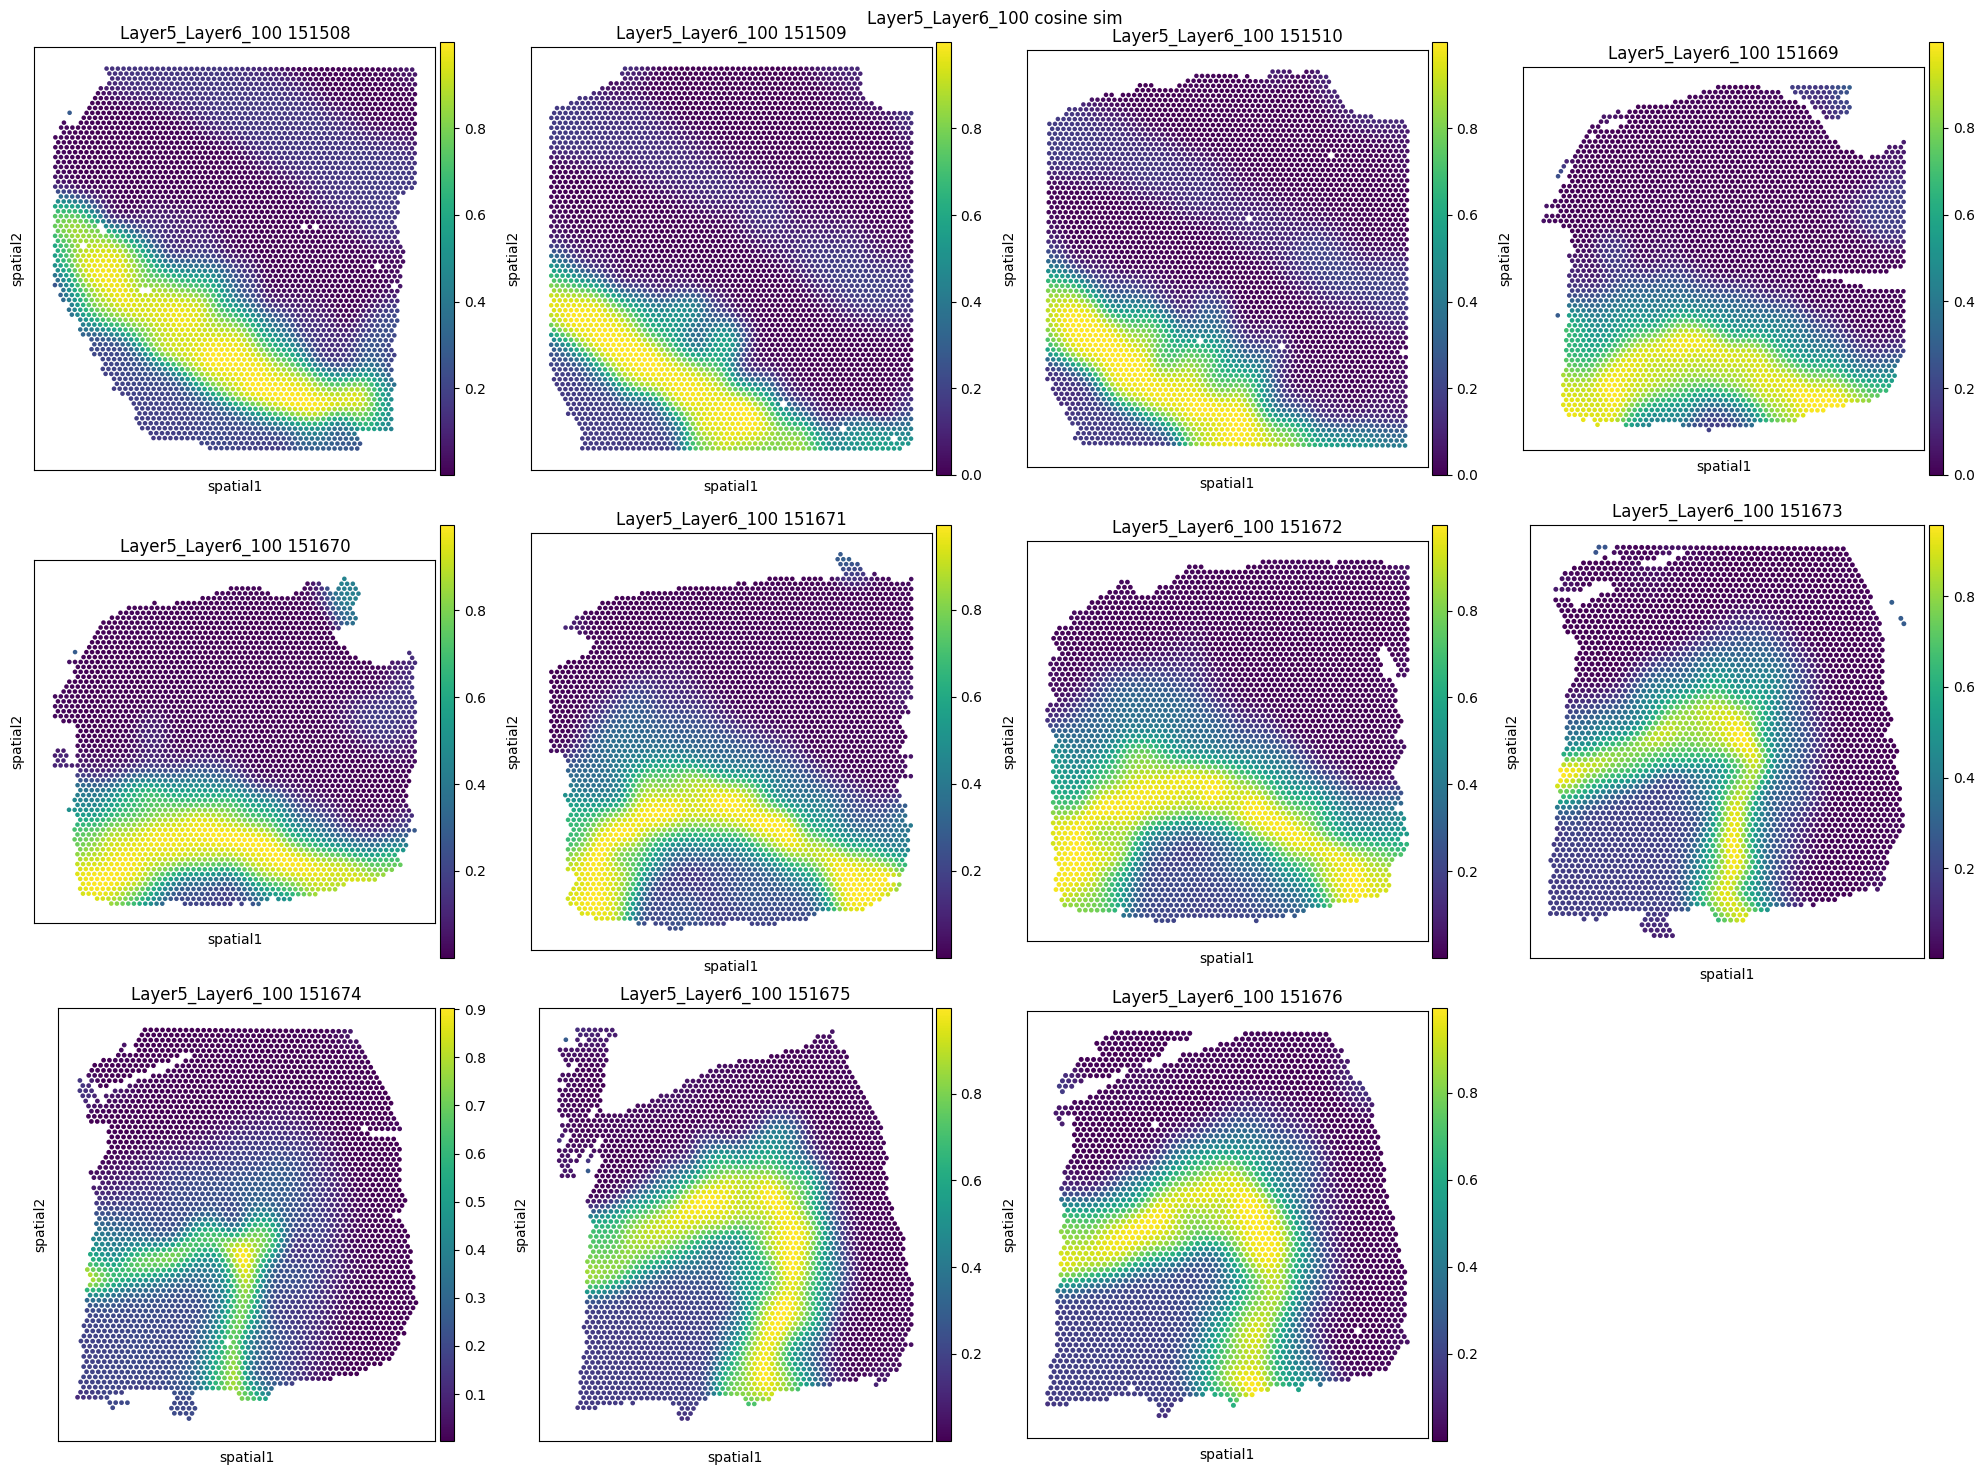

In [8]:
for niche_prefix in niche_prefix_list:
    logger.info(f"plotting query results for niche {niche_prefix}, time: {bench_utils.get_time_str()}")
    fig, axs = plt.subplots(3, 4, figsize=(20, 15))  # figsize is (col, row)
    sup_title = f"{niche_prefix} cosine sim"
    axs = axs.flatten()
    fig.suptitle(sup_title)
    for i, (adata_ref, ref_id) in enumerate(zip(adata_ref_list, ref_id_list)):
        spot_size = model_utils.get_spot_size(dataset, ref_id)
        axs[i].invert_yaxis()
        sc.pl.spatial(adata_ref, color=f"{niche_prefix}_sim", ax=axs[i], spot_size=spot_size, show=False, title=f"{niche_prefix} {ref_id}")
    axs[11].axis('off')  # remove query sample frame
fig.tight_layout()
plt.show()